<a href="https://colab.research.google.com/github/aKaRagnarAuCollierRouge/AnalyseCompteBancaireProjet/blob/main/Projet_AnalyseCompteBancaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Analyse d'un Compte bancaire avec Python

## 1) Importation des données du compte bancaire + packages




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st

In [ ]:
donnees= pd.read_csv("sample_data/operations.csv")

# Vérification de l'importation des données
donnees.head(5)

,date_operation,libelle,montant,solde_avt_ope,categ
0,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE
1,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT
2,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT
3,2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE
4,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE


In [ ]:
donnees.shape

(309, 5)

Nous avons dans notre jeu de données:
* 309 transactions
* 5 variables (date_operation,libelle,montant,solde_avt_ope,categ)

## 2) Nettoyer le jeu de données

### Vérification que les données sont importés dans le bon type

In [ ]:
donnees.dtypes

,0
date_operation,object
libelle,object
montant,float64
solde_avt_ope,float64
categ,object


La variable date n'est pas du type date, nous arrangons donc celà:

In [ ]:
donnees['date_operation'] = pd.to_datetime(donnees['date_operation'])

### Essayons de regardez si on trouve des VALEURS MANQUANTES

In [ ]:
donnees.isnull().sum()

,0
date_operation,0
libelle,0
montant,2
solde_avt_ope,0
categ,1


On remarque qu'il manque 2 valeurs manquantes sur le montant et 1 sur la catégorie.

Affichons les variables avec une valeure manquante pour la variable montant

In [ ]:
donnees.loc[donnees['montant'].isnull(),:]

,date_operation,libelle,montant,solde_avt_ope,categ
107,2023-06-12,CARTE XX XX LES ANCIENS ROBINSON XX,NaN,4667.19,COURSES
269,2023-09-11,CARTE XX XX XX XX,NaN,3401.93,AUTRE


On peut déduire le montant de l'opération manquante, en effet les datas sont disposés en ligne par ordre chronologique donc avec le solde de la ligne précédente et la ligne actuelle on peut déduire le montant.

In [ ]:
# on stocke le df des valeurs manquantes dans un nouveau df
data_na = donnees.loc[donnees['montant'].isnull(),:]

# pour chaque ligne de mon df, on récupère les index (qui ne changent pas au travers du .loc)
for index in data_na.index:
    # calcul du montant à partir des soldes précédents et actuels
    donnees.loc[index, 'montant'] = donnees.loc[index+1, 'solde_avt_ope'] - donnees.loc[index, 'solde_avt_ope']

Regardons la valeur manquant pour catégorie:

In [ ]:
donnees.loc[donnees['categ'].isnull(),:]

,date_operation,libelle,montant,solde_avt_ope,categ
156,2023-07-06,PRELEVEMENT XX TELEPHONE XX XX,-36.48,3295.68,NaN


Je vais essayé de regardé  si le libelle correspond à d'autres lignes pour trouver la catégorie

In [ ]:
donnees.loc[donnees['libelle'] == 'PRELEVEMENT XX TELEPHONE XX XX', :]

,date_operation,libelle,montant,solde_avt_ope,categ
8,2023-04-05,PRELEVEMENT XX TELEPHONE XX XX,-7.02,2056.02,FACTURE TELEPHONE
62,2023-05-09,PRELEVEMENT XX TELEPHONE XX XX,-7.02,4090.10,FACTURE TELEPHONE
102,2023-06-07,PRELEVEMENT XX TELEPHONE XX XX,-6.38,4688.91,FACTURE TELEPHONE
156,2023-07-06,PRELEVEMENT XX TELEPHONE XX XX,-36.48,3295.68,NaN
204,2023-08-07,PRELEVEMENT XX TELEPHONE XX XX,-7.46,3751.73,FACTURE TELEPHONE
260,2023-09-05,PRELEVEMENT XX TELEPHONE XX XX,-6.38,3453.96,FACTURE TELEPHONE
308,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,2413.58,FACTURE TELEPHONE


Je vois que la catégori est "FACTURE TELEPHONE" donc il ne me reste plus qu'à ajouter la donnée manquant

In [ ]:
donnees.loc[donnees['categ'].isnull(), 'categ'] = 'FACTURE TELEPHONE'

### Je veux corriger à présent les éventuelles DOUBLONS.

In [ ]:
donnees.loc[donnees[['date_operation', 'libelle', 'montant', 'solde_avt_ope']].duplicated(keep=False),:]

,date_operation,libelle,montant,solde_avt_ope,categ
43,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES
44,2023-04-25,CARTE XX XX LES ANCIENS ROBINSON XX,-32.67,3647.67,COURSES


Je remarque su'il y a 1 doublon par conséquent je veux le supprimer

In [ ]:
donnees.drop_duplicates(subset=['date_operation', 'libelle', 'montant', 'solde_avt_ope'], inplace=True, ignore_index=True)

### Detections des outliers

In [ ]:
donnees.describe()

,date_operation,montant,solde_avt_ope
count,308,308.000000,308.000000
mean,2023-07-05 10:59:13.246753280,-45.782013,3395.301071
min,2023-03-31 00:00:00,-15000.000000,1416.810000
25%,2023-05-21 06:00:00,-20.447500,3010.737500
50%,2023-07-05 12:00:00,-9.600000,3452.465000
75%,2023-08-21 00:00:00,-2.715000,3787.232500
max,2023-10-06 00:00:00,1071.600000,4709.310000
std,NaN,872.818105,667.109412


Je remarque que des outliers sont présents , en effet lorsque l'on regarde le minimum, le maximum et la moyenne , celà semble évident (min=-15000, max=1071). Le minimum a l'air d'être abbérant , par conséquent vérifions qu'il n'y a pas d'incohérence

In [ ]:
i = donnees.loc[donnees['montant']==-15000,:].index[0]

donnees.iloc[i-1:i+2,:]

,date_operation,libelle,montant,solde_avt_ope,categ
197,2023-08-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,3121.35,AUTRE
198,2023-08-03,CARTE XX XX XX XX,-15000.00,3797.35,AUTRE
199,2023-08-03,CARTE XX XX L'EPICERIE DEMBAS XX XX,-10.51,3782.96,AUTRE


Ok donc je remarque que la solde ne correspond pas à la transaction , par conséquent on peut relevé une erreur. Le montant devrait être de -3787.35+3782.96=-14.39. Donc modifions cette donnée

In [ ]:
donnees.loc[donnees["montant"]==-15000,"montant"]=14.39

## 3) Représentation de la distribution empirique d'une variable

### 1. Variables qualitatives

Voici la distribution empirique de la variable categorie

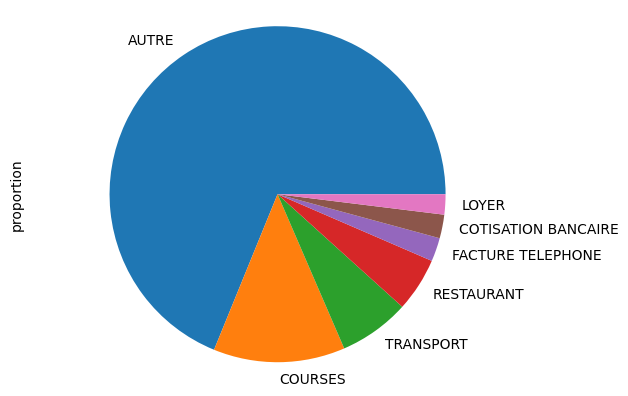

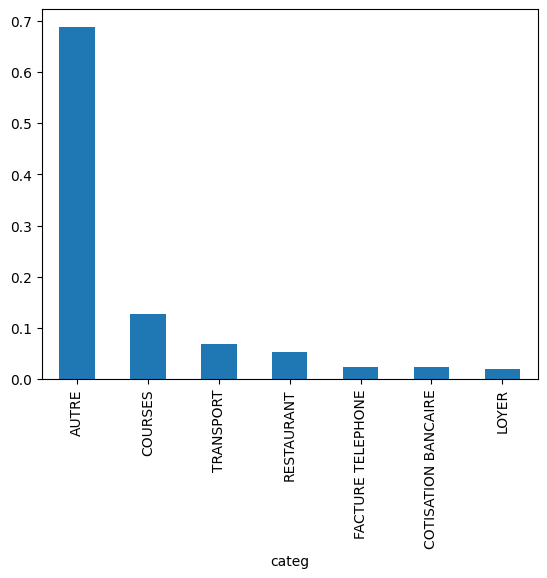

In [ ]:
donnees["categ"].value_counts(normalize=True).plot(kind='pie')

plt.axis("equal")
plt.show()

donnees["categ"].value_counts(normalize=True).plot(kind="bar")
plt.show()

### Variables quantitatives

Représentons les variables quantititaves discrètes sont formes de diagramme en bâtons. Distribuons les données selon le quart du mois pour compter les données.


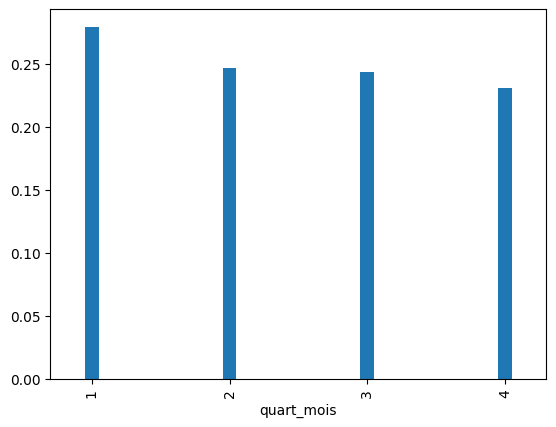

In [ ]:
#Ajout de "quart_mois" à notre DataFrame
donnees["quart_mois"]=[int((jour-1)*4/31)+1 for jour in donnees["date_operation"].dt.day]

# Diagramme bâton
donnees["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()


Pour les variables continues on va utiliser un histogramme où la largeur du rectangle est proportionnelle à la largeur de la classe

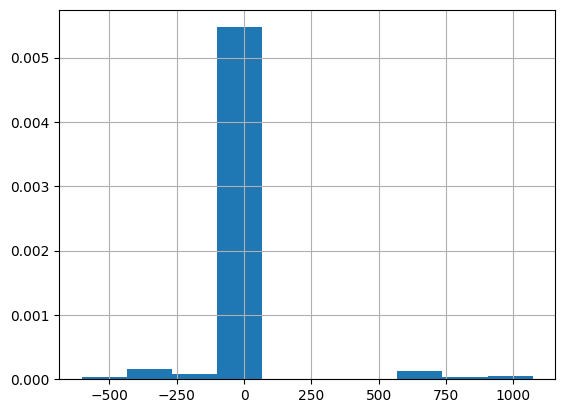

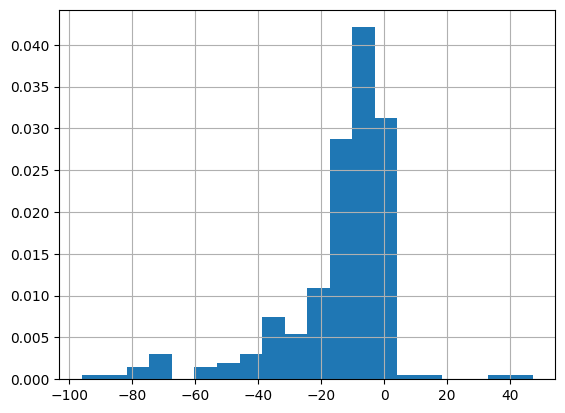

In [ ]:
# Histogramme
donnees["montant"].hist(density=True)
plt.show()

# Autre histogramme
donnees[donnees.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()

## 4) Présentation des variables sous forme de tableaux

Représentation de la variable quart_mois sous forme de tableau

In [ ]:
effectifs=donnees["quart_mois"].value_counts()
modalites= effectifs.index
tab= pd.DataFrame(modalites,columns=["quart_mois"])
tab["n"]=effectifs.values
tab["f"]=tab["n"] / len(donnees)

display(tab)

,quart_mois,n,f
0,1,86,0.279221
1,2,76,0.246753
2,3,75,0.243506
3,4,71,0.230519


Calculs des fréquences cumulés(F) pour s'assurer que cette somme est égal à 1

In [ ]:
tab=tab.sort_values("quart_mois")
tab["F"]=tab["f"].cumsum()

display(tab)

,quart_mois,n,f,F
0,1,86,0.279221,0.279221
1,2,76,0.246753,0.525974
2,3,75,0.243506,0.769481
3,4,71,0.230519,1.000000


## 5) Afficher des Mesures de tendance centrale

Calcul du monde du montant dépensé

In [ ]:
donnees["montant"].mode()

,montant
0,-1.6


Calcul de la moyenne des montant dépensés

In [ ]:
donnees["montant"].mean()

2.9660064935064936

Analysons un peu plus en détail notre variable montant.

Les montants des opérations sont très hétérogènes : il y a des dépenses (à montant négatif) parfois grosses (les loyers, par exemple), souvent petites (courses, téléphone, etc.), et il y a des rentrées d'argent (à montant positif), peu fréquentes mais grosses. Difficile donc d'interpréter la moyenne (très sensible aux valeurs atypiques) qui vaut ici 2,87 €.

On a le même problème pour la médiane qui vaut -9,6 €. Le fait qu'elle soit négative nous indique cependant qu'il y a plus de dépenses que d'entrées d'argent. Par contre, le mode nous indique que la plupart des opérations tournent autour de -1,6 €. Ici, les 3 mesures sont très éloignées les unes des autres.

Pour avoir des montants d'opérations plus homogènes, il serait intéressant de calculer ces mesures pour chaque catégorie d'opération : les montants devraient être moins éparpillés au sein d'une catégorie puisque les opérations sont de même nature

--------------------
AUTRE
moy:
 23.56896226415094
med:
 -8.07
mod:
 0   -1.6
Name: montant, dtype: float64


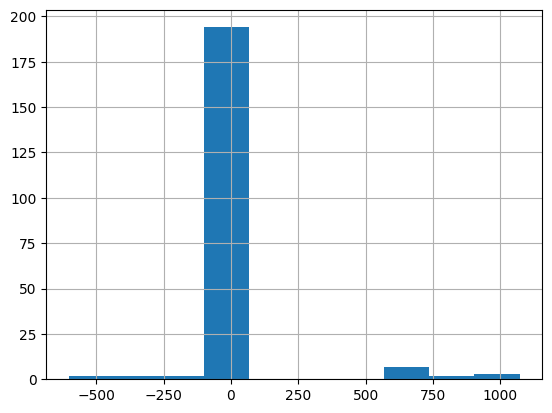

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
Name: montant, dtype: float64


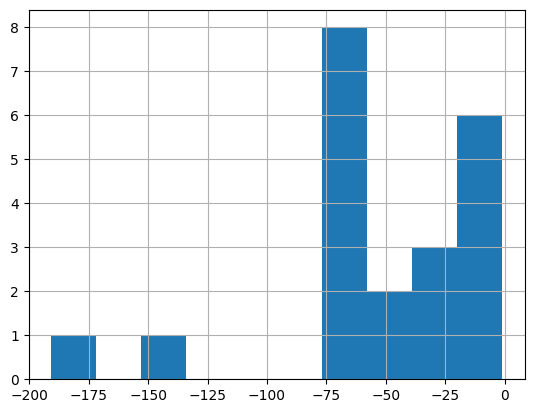

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
Name: montant, dtype: float64


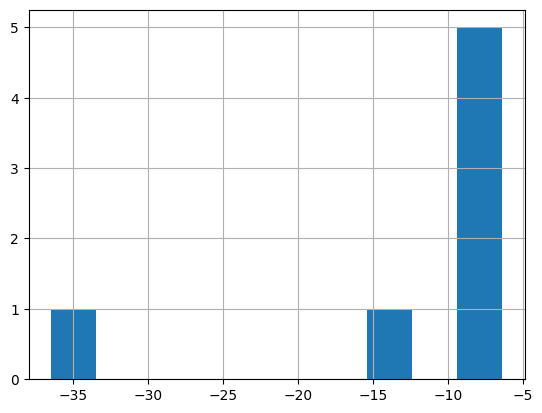

--------------------
COURSES
moy:
 -16.34128205128205
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
Name: montant, dtype: float64


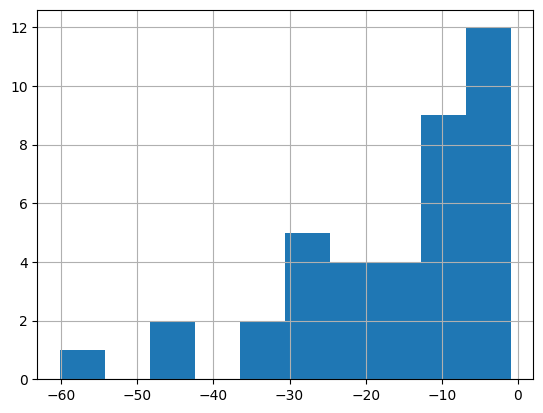

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
Name: montant, dtype: float64


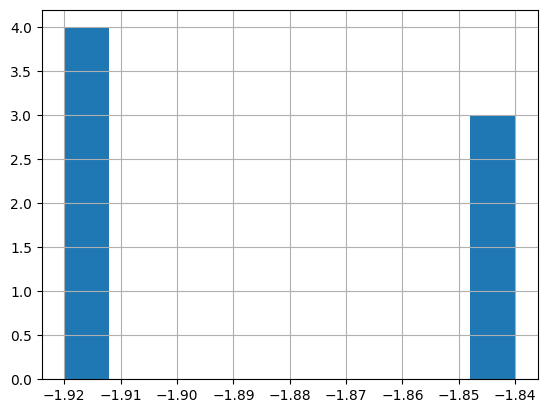

--------------------
RESTAURANT
moy:
 -10.3325
med:
 -10.1
mod:
 0   -9.2
Name: montant, dtype: float64


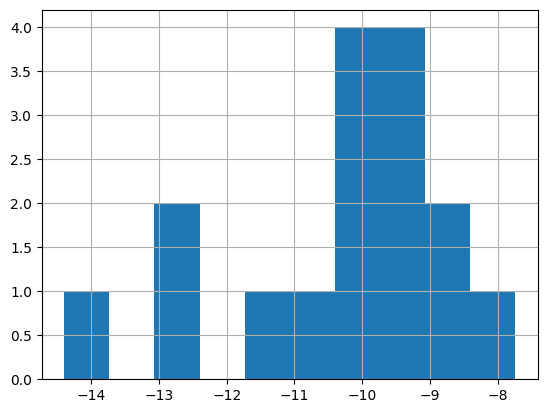

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
Name: montant, dtype: float64


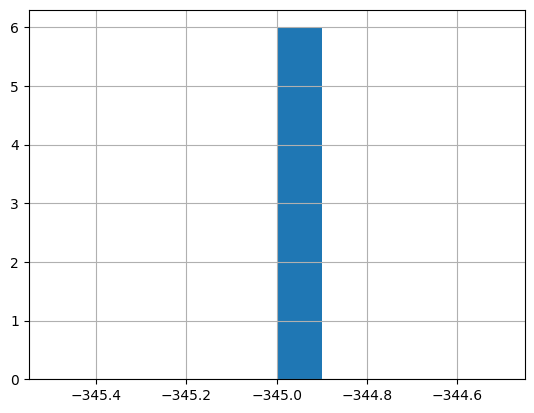

In [ ]:
for cat in donnees["categ"].unique():
    subset = donnees.loc[donnees.categ == cat, :] # Création du sous-échantillon
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    subset["montant"].hist() # Crée l'histogramme
    plt.show() # Affiche l'histogramme

On remarque que toutes les catégories mis à part la catégorie AUTRES sont des dépenses. Dans la catégorie AUTRES, il y a des rentrées d'argent comme son salaire.

## 5) Calcul de la Variance & Ecart Type

In [ ]:
donnees["montant"].var()

31007.090698332202

Calcul corrigé de la variance

In [ ]:
donnees["montant"].var(ddof=0)

30906.418325935017

Ecart type pour la variable montant

In [ ]:
donnees['montant'].std()

176.08830369542494

Calcul du coefficient de variation

In [ ]:
donnees['montant'].std(ddof=0)

175.80221365482012

Boîte à moustache

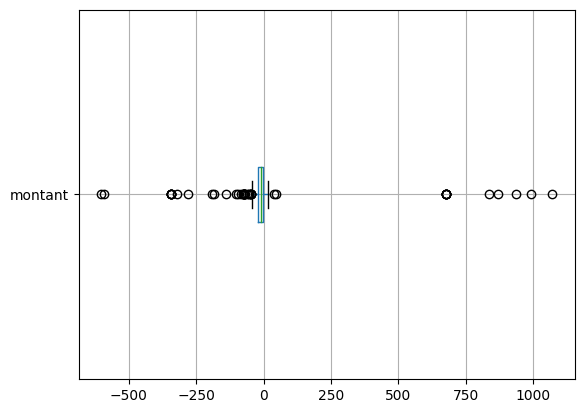

In [ ]:
donnees.boxplot(column="montant", vert=False)
plt.show()

Analyse pour l'ensemble des variables

--------------------
AUTRE
moy:
 23.56896226415094
med:
 -8.07
mod:
 0   -1.6
Name: montant, dtype: float64
var:
 40395.4492262816
ect:
 200.98619163087199


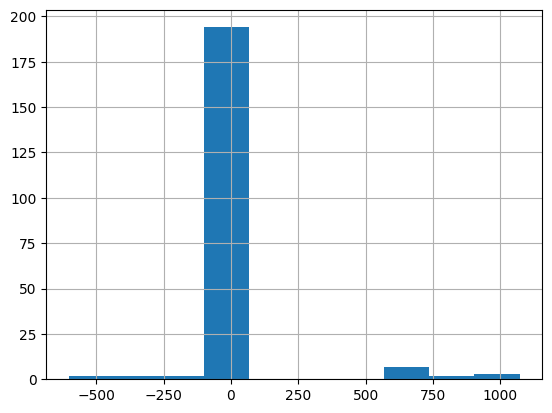

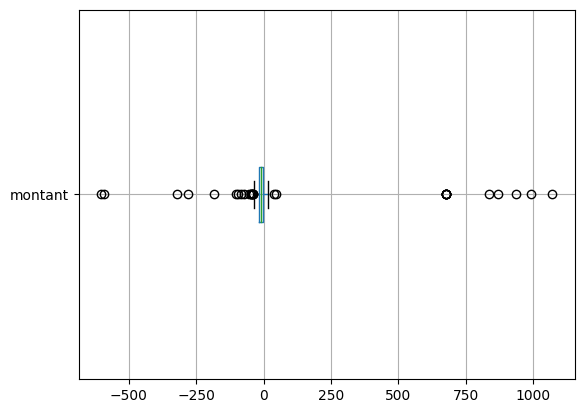

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
Name: montant, dtype: float64
var:
 2205.0168680272113
ect:
 46.95760713694014


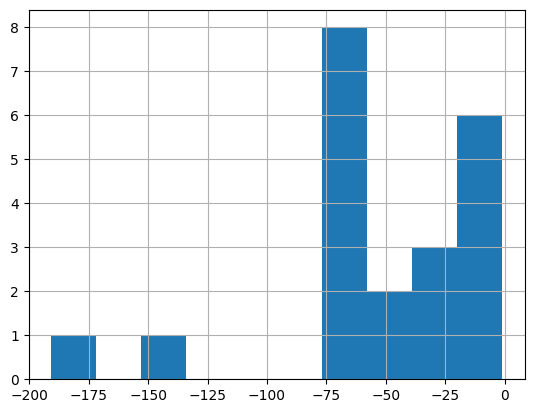

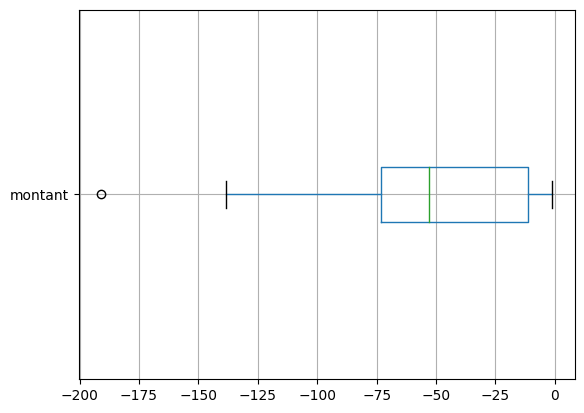

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
Name: montant, dtype: float64
var:
 105.01905306122445
ect:
 10.247880417980317


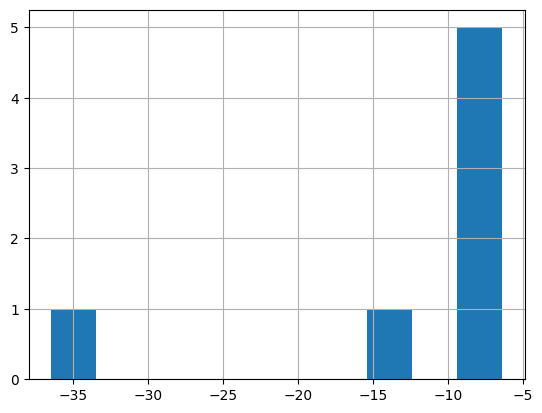

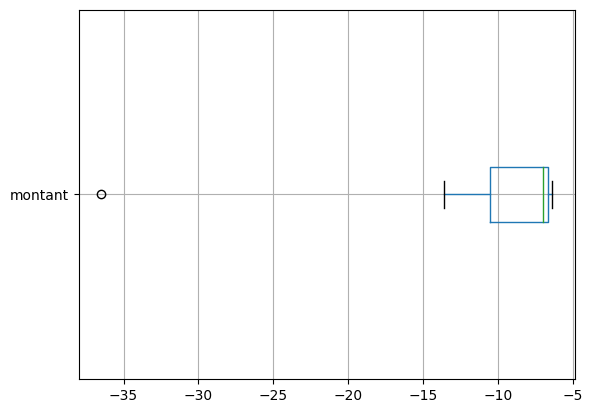

--------------------
COURSES
moy:
 -16.34128205128205
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
Name: montant, dtype: float64
var:
 177.02535476660088
ect:
 13.3050875520081


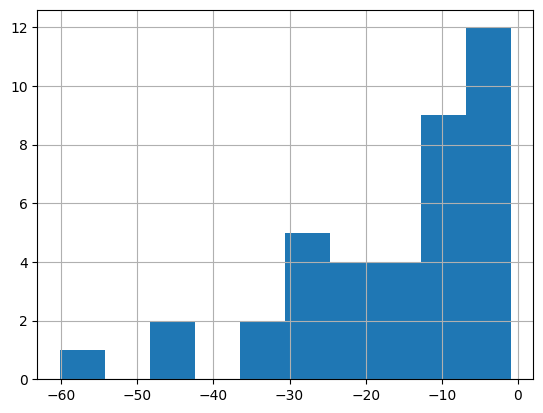

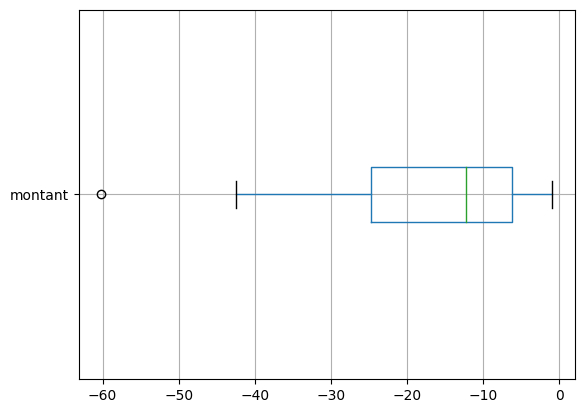

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
Name: montant, dtype: float64
var:
 0.0015673469387755044
ect:
 0.03958973274443141


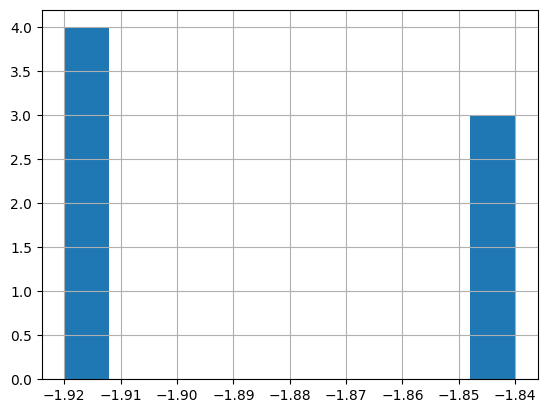

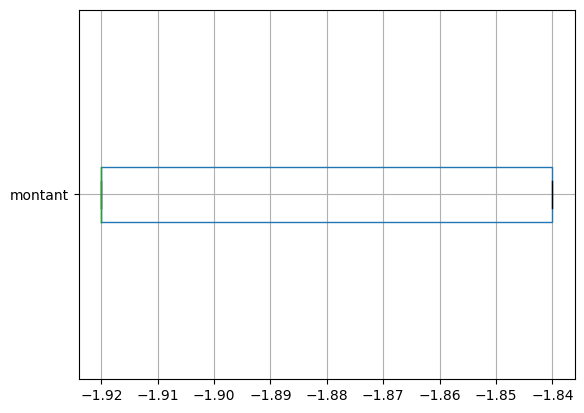

--------------------
RESTAURANT
moy:
 -10.3325
med:
 -10.1
mod:
 0   -9.2
Name: montant, dtype: float64
var:
 2.8531937500000004
ect:
 1.689139943876765


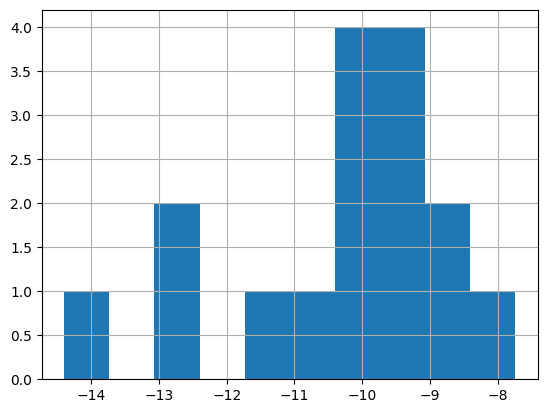

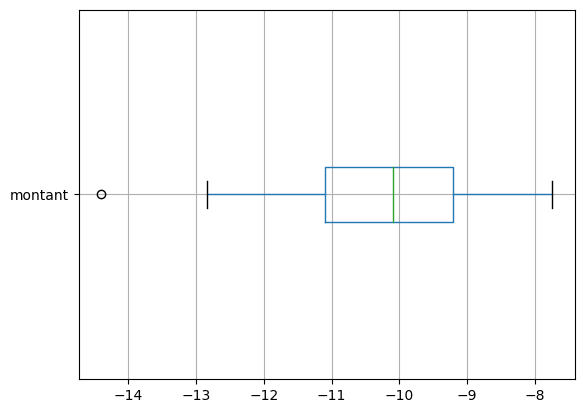

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
Name: montant, dtype: float64
var:
 0.0
ect:
 0.0


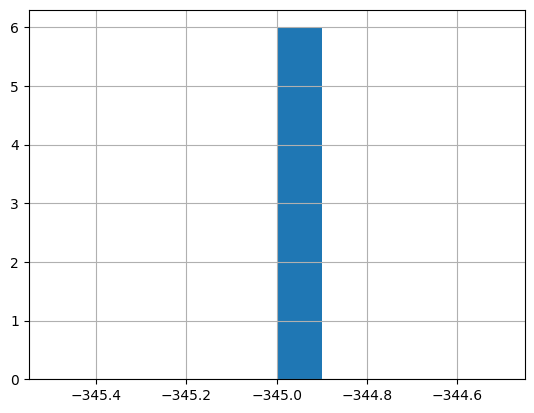

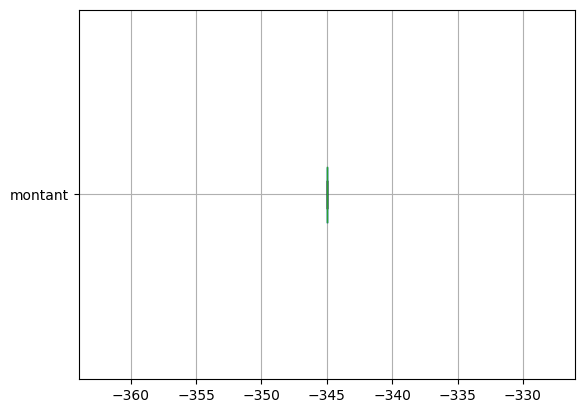

In [ ]:
for cat in donnees["categ"].unique():
    subset = donnees[donnees.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()

## 7) Les mesures de Forme

Le calcul du skewness se fait très facilement en Python :

In [ ]:
donnees["montant"].skew()

3.3603356728697267

Voilà comment calculer le kurtosis de notre variable montant :

In [ ]:
donnees["montant"].kurt()

17.265393380003264

--------------------
AUTRE
moy:
 23.56896226415094
med:
 -8.07
mod:
 0   -1.6
Name: montant, dtype: float64
var:
 40395.4492262816
ect:
 200.98619163087199
skw:
 3.120262587179789
kur:
 12.712936944845938


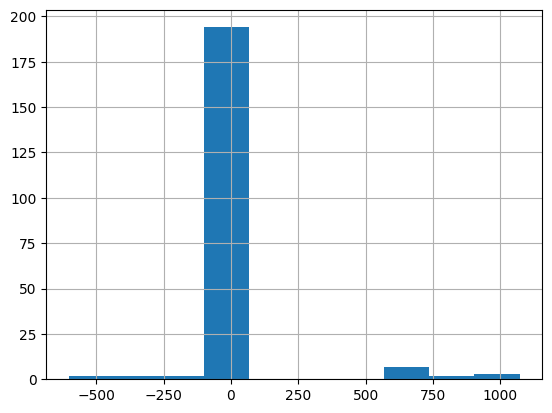

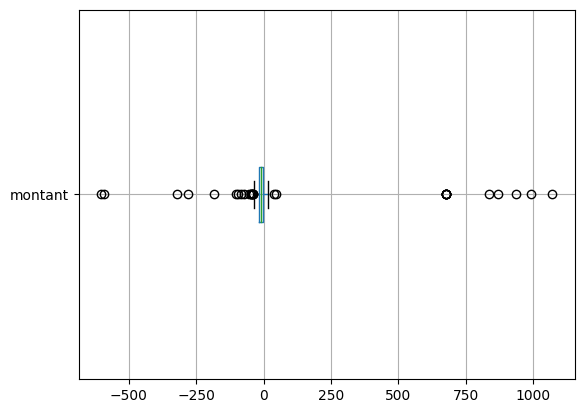

--------------------
TRANSPORT
moy:
 -52.99714285714286
med:
 -53.1
mod:
 0   -73.0
Name: montant, dtype: float64
var:
 2205.0168680272113
ect:
 46.95760713694014
skw:
 -1.248265076217821
kur:
 2.1922705326917495


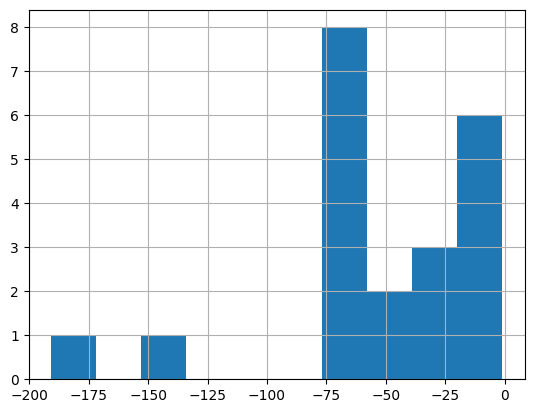

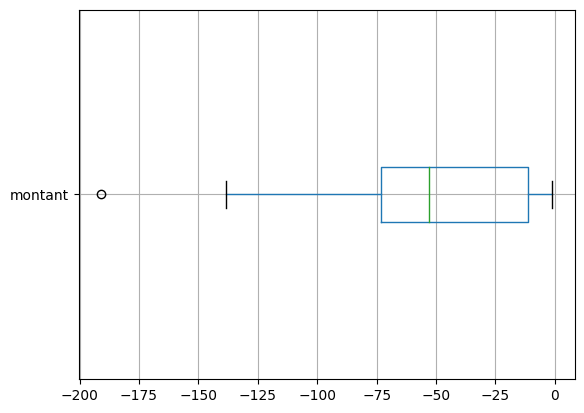

--------------------
FACTURE TELEPHONE
moy:
 -12.045714285714283
med:
 -7.02
mod:
 0   -7.02
1   -6.38
Name: montant, dtype: float64
var:
 105.01905306122445
ect:
 10.247880417980317
skw:
 -2.3876514564281526
kur:
 5.798563367885492


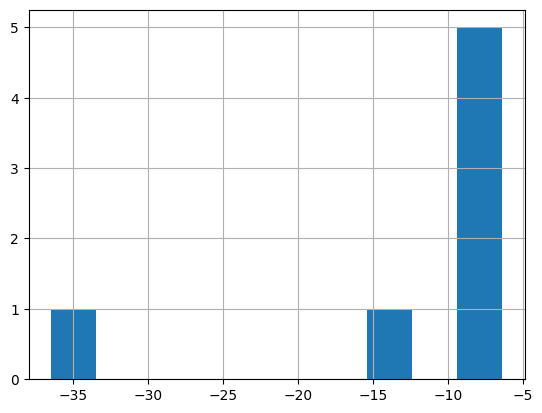

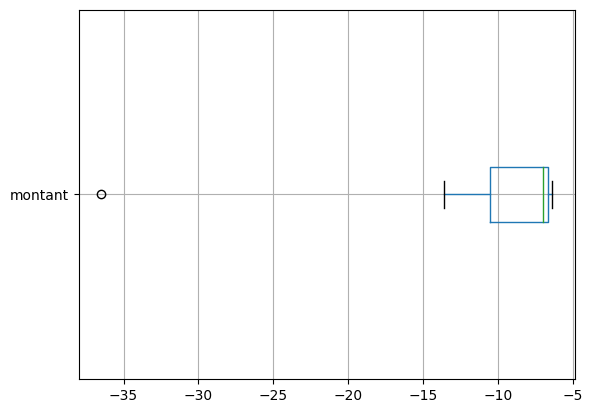

--------------------
COURSES
moy:
 -16.34128205128205
med:
 -12.24
mod:
 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
Name: montant, dtype: float64
var:
 177.02535476660088
ect:
 13.3050875520081
skw:
 -1.2467488306456982
kur:
 1.6047304940874998


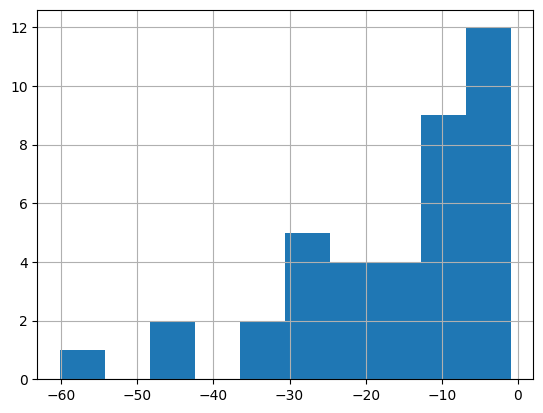

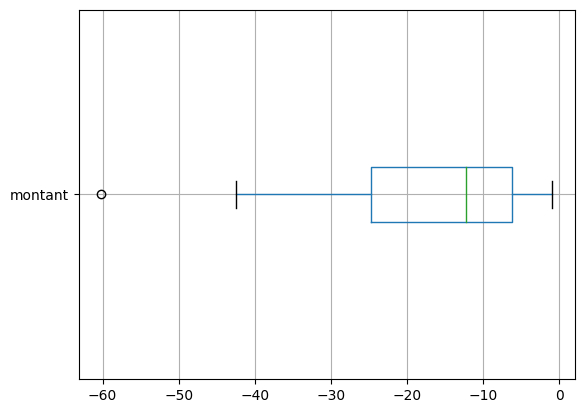

--------------------
COTISATION BANCAIRE
moy:
 -1.8857142857142857
med:
 -1.92
mod:
 0   -1.92
Name: montant, dtype: float64
var:
 0.0015673469387755044
ect:
 0.03958973274443141
skw:
 0.37416573867739106
kur:
 -2.800000000000003


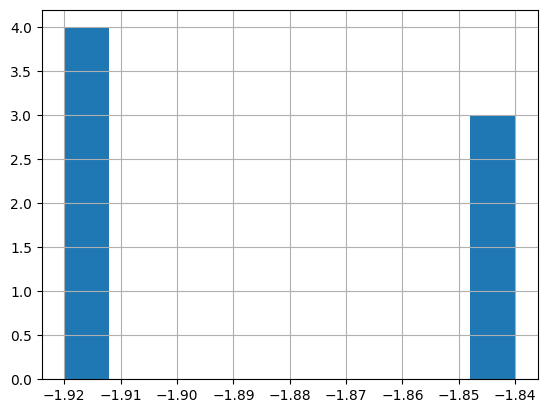

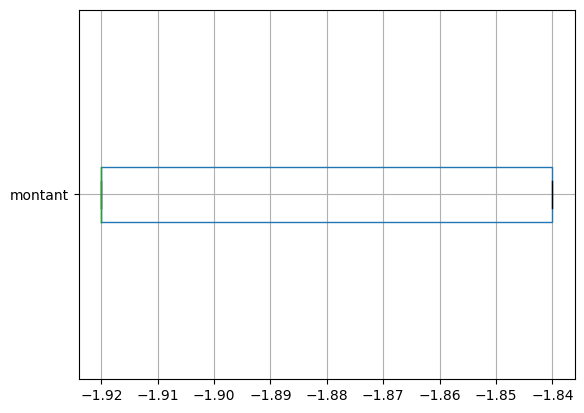

--------------------
RESTAURANT
moy:
 -10.3325
med:
 -10.1
mod:
 0   -9.2
Name: montant, dtype: float64
var:
 2.8531937500000004
ect:
 1.689139943876765
skw:
 -0.8883503487158837
kur:
 0.5988855591691937


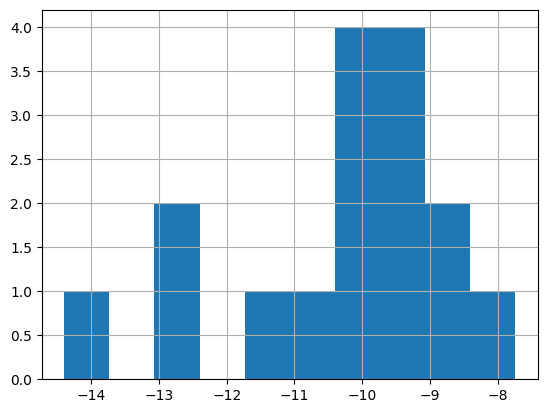

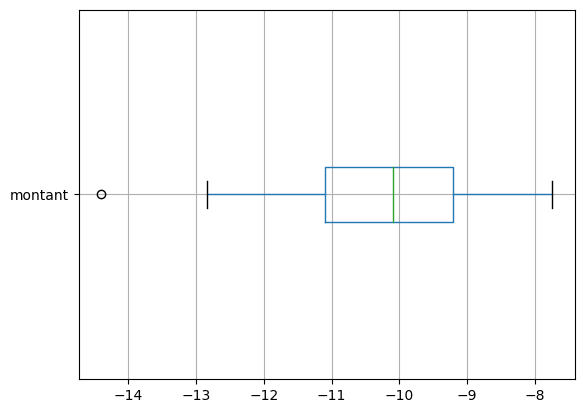

--------------------
LOYER
moy:
 -345.0
med:
 -345.0
mod:
 0   -345.0
Name: montant, dtype: float64
var:
 0.0
ect:
 0.0
skw:
 0.0
kur:
 0.0


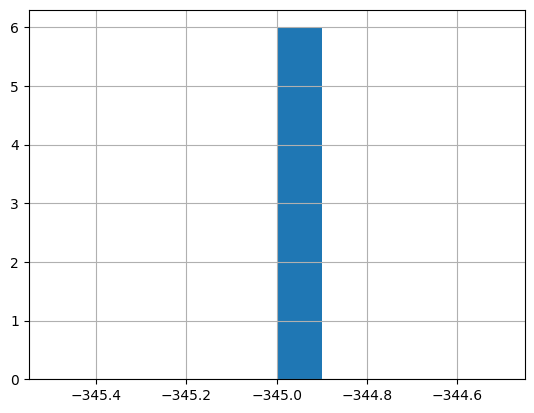

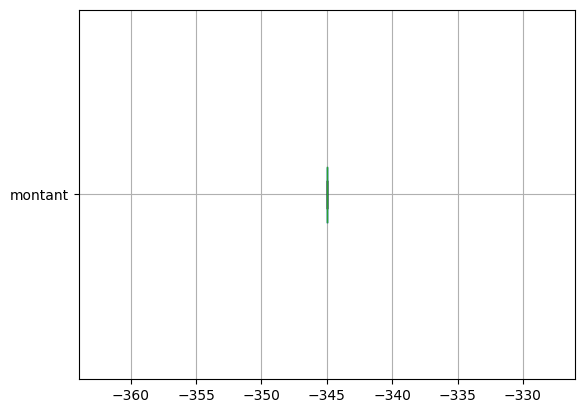

In [ ]:
for cat in donnees["categ"].unique():
    subset = donnees[donnees.categ == cat]
    print("-"*20)
    print(cat)
    print("moy:\n",subset['montant'].mean())
    print("med:\n",subset['montant'].median())
    print("mod:\n",subset['montant'].mode())
    print("var:\n",subset['montant'].var(ddof=0))
    print("ect:\n",subset['montant'].std(ddof=0))
    print("skw:\n",subset['montant'].skew())
    print("kur:\n",subset['montant'].kurtosis())
    subset["montant"].hist()
    plt.show()
    subset.boxplot(column="montant", vert=False)
    plt.show()

## Analyse Bivariée

Je veux essayer de répondre à la question suivante: Est ce que je suis - dépensier lorsque j'ai peu d'argent?

Pour celà je dois réaliser une analye bivarié sur les variables: "montant" & "solde_avt_operation". En effet il faut chercher une corrélation entre ses deux variables en se demandant: si mon solde est petit est ce que les opérations vont être plus petites.

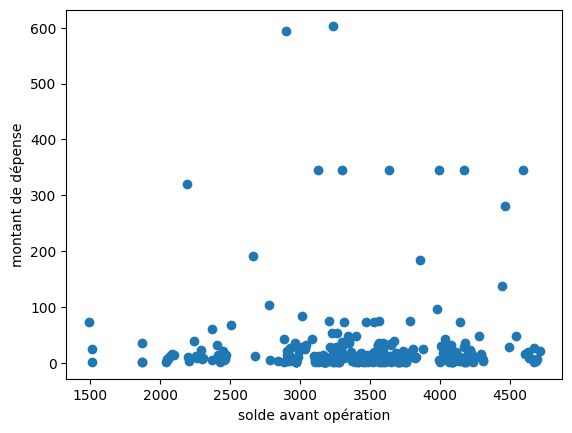

In [ ]:
depenses=donnees[donnees.montant<0]
plt.plot(depenses["solde_avt_ope"],-depenses["montant"],"o")
plt.xlabel("solde avant opération")
plt.ylabel("montant de dépense")
plt.show()

Les dépenses ne sont pas forcément + petites avec un compte bas.

Autre visualisation:

In [ ]:
taille_classe = 500 # taille des classes pour la discrétisation

groupes = [] # va recevoir les données agrégées à afficher

# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, max(depenses["solde_avt_ope"]), taille_classe)
tranches += taille_classe/2 # on décale les tranches d'une demi taille de classe
indices = np.digitize(depenses["solde_avt_ope"], tranches) # associe chaque solde à son numéro de classe

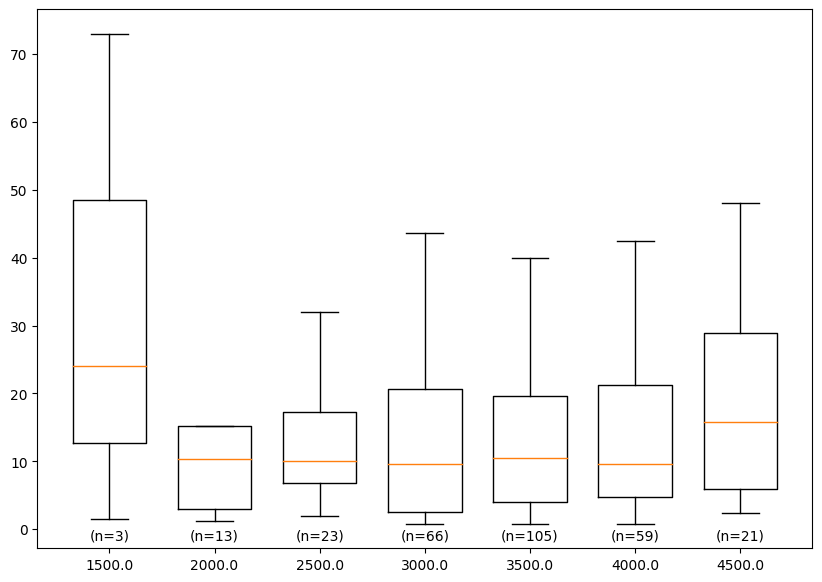

In [ ]:
for ind, tr in enumerate(tranches): # pour chaque tranche, ind reçoit le numéro de tranche et tr la tranche en question
    montants = -depenses.loc[indices==ind,"montant"] # sélection des individus de la tranche ind
    if len(montants) > 0:
        g = {
            'valeurs': montants,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(montants),
            'quartiles': [np.percentile(montants,p) for p in [25,50,75]]
        }
        groupes.append(g)

plt.figure(figsize=(10,7))

# affichage des boxplots
plt.boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.7) # largeur graphique des boxplots

# affichage des effectifs de chaque classe
for g in groupes:
    plt.text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')
plt.show()

On va calculer le coefficient de Person pour avoir un test statique qui valide mon infirmation

In [ ]:
print(st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0])
print(np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[1,0])

0.010484401156040504
506.3928607919165


## 7)Analyse via la régression linéaire

Je veux savoir si + le temps d'attente avant la prochaine opération est longue, + le montant de la prochaine opération va être élevé. Hypothèse: + on attend avant de faire les courses , + on a besoin de provision.

In [ ]:
# Selection du sous-échantillon
courses = donnees.loc[donnees.categ == "COURSES", :]

# On trie les opérations par date
courses = courses.sort_values("date_operation")

# On ramène les montants en positif
courses["montant"] = -courses["montant"]

# calcul de la variable attente
r = []
last_date = dt.datetime.now()
for i,row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    last_date = row["date_operation"]
courses["attente"] = r
courses = courses.iloc[1:,]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = courses.groupby("date_operation")["montant"].sum()
b = courses.groupby("date_operation")["attente"].first()
courses = pd.DataFrame({"montant":a, "attente":b})

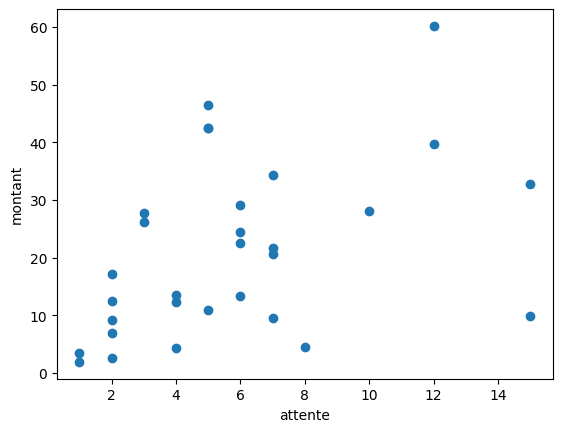

In [ ]:
plt.plot(courses['attente'],courses['montant'], "o")
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

In [ ]:
import statsmodels.api as sm

Y = courses['montant']
X = courses[['attente']]
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']

Tracer la droite de régression avec les coefficients obtenus:

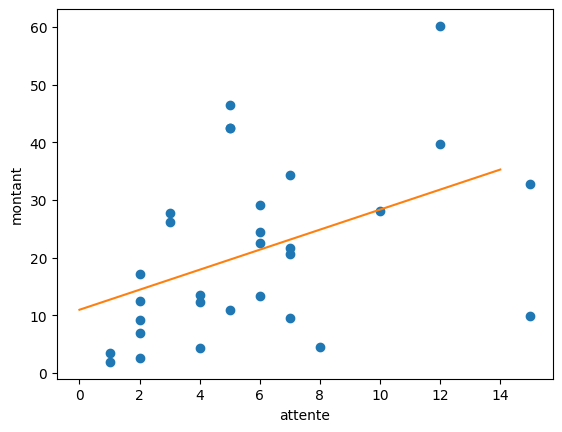

In [ ]:
plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

Enlevons maintenant les outliers et réeffectuons une régression linéaire.

attente      3.030823
intercept    5.411480
dtype: float64


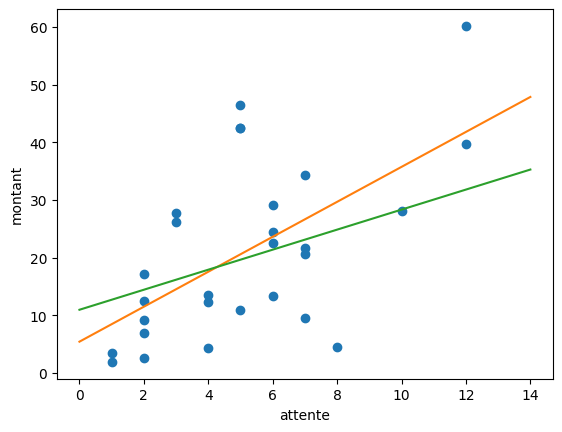

In [ ]:
courses = courses.loc[courses['attente'] < 15, :]

Y = courses['montant']
X = courses[['attente']]
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a_new,b_new = result.params['attente'],result.params['intercept']

print(result.params)

plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a_new*x+b_new for x in np.arange(15)])
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

## VIII) Analyse variable quantitative & qualitative avec ANOVA

In [ ]:
X="categ"
Y="montant"
# dépenses
sous_echantillon=donnees.loc[donnees["montant"] < 0, :].copy()
# je remets les dépenses en positif
sous_echantillon["montant"]= - sous_echantillon["montant"]
# retire les loyers de l'étude car trop important et fixe
sous_echantillon= sous_echantillon.loc[sous_echantillon["categ"]!="LOYER", :]

Graphique permettant de représenter la variable quantitative et qualitative

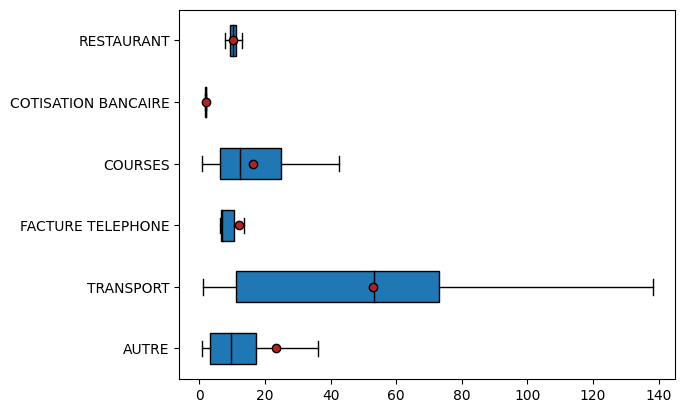

In [ ]:
modalites=sous_echantillon[X].unique()
groupes=[]
for m in modalites:
  groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

# Propriété graphiques (pas très importantes)
medianprops={"color":"black"}
meanprops={"marker" : "o","markeredgecolor":"black",
           "markerfacecolor":"firebrick"}
plt.boxplot(groupes,labels=modalites, showfliers= False,medianprops=medianprops,vert=False,patch_artist=True,showmeans=True,meanprops=meanprops)
plt.show()

On voit ici que les montants sont très différents d'une catégorie à l'autre. Par exemple, les montants des dépenses de transport sont plus élevés et plus dispersés que ceux des factures téléphoniques. Mais vérifions maintenant cette affirmation par les chiffres, grâce à une modélisation.

In [ ]:
X = "categ" # qualitative
Y = "montant" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

eta_squared(sous_echantillon[X],sous_echantillon[Y])

0.027530983679803087

Je vais analyser la variable quart_mois avec le montant des achats , en effet il est intérressant de savoir si l'on dépense plus où moins au début de mois par exemple.

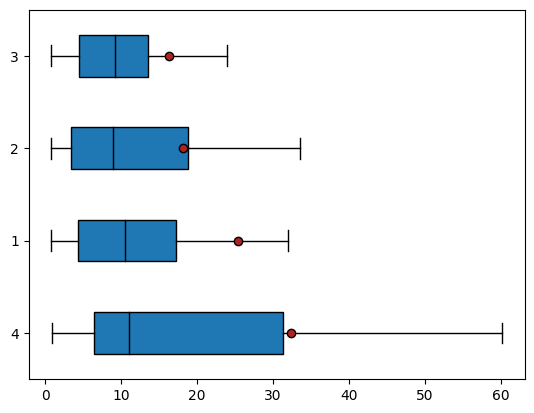

0.011443556059323364

In [ ]:
X="quart_mois" #qualitatif
Y="montant" #quantitatif

modalites= sous_echantillon[X].unique()
groupes=[]
for m in modalites:
  groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
#Propriétés graphiques pas très importantes
medianprops={"color":"black"}
meanprops={"marker":"o","markeredgecolor":"black","markerfacecolor":"firebrick"}
plt.boxplot(groupes,labels=modalites,showfliers=False,medianprops=medianprops,
            vert=False,patch_artist=True,showmeans=True,meanprops=meanprops)

plt.show()

eta_squared(sous_echantillon[X],sous_echantillon[Y])



## IX) Analyser 2 variables qualitatives avec Khi-2

Je vais analyser 2 variables qualitatives quart_mois et categories

In [ ]:
X = "quart_mois"
Y = "categ"

cont = donnees[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,AUTRE,COTISATION BANCAIRE,COURSES,FACTURE TELEPHONE,LOYER,RESTAURANT,TRANSPORT,Total
quart_mois,,,,,,,,
1,55.0,7.0,6.0,6.0,NaN,3.0,9.0,86
2,45.0,NaN,11.0,1.0,6.0,7.0,6.0,76
3,60.0,NaN,7.0,NaN,NaN,4.0,4.0,75
4,52.0,NaN,15.0,NaN,NaN,2.0,2.0,71
Total,212.0,7.0,39.0,7.0,6.0,16.0,21.0,308


Je vais créer une heatmap et colorré chaque case en fonction du test de KHI2 pour évaluer les potentiels corrélations:

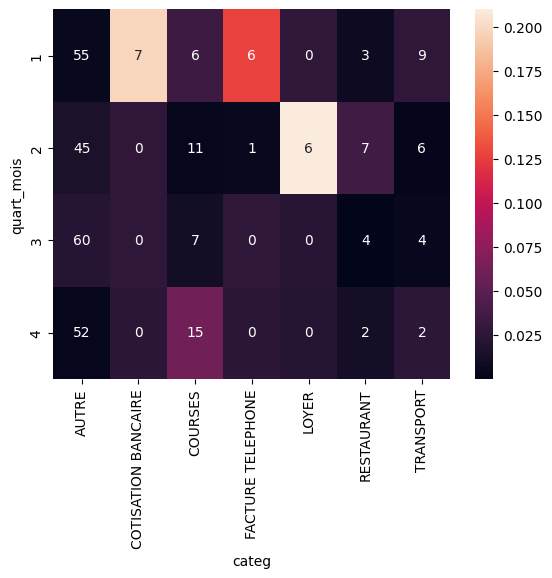

In [ ]:
import seaborn as sns

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(donnees)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()